# 1 Dataset Information - Twitter Climate Change Sentiment

**Attribute Information**


* **Sentiment:** Identfied classes of the tweet by 3 reviewers.
 *  2 (News): the tweet links to factual news about climate change
 *  1 (Pro): the tweet supports the belief of man-made climate change
 *  0 (Neutral: the tweet neither supports nor refutes the belief of man-made climate change
 * -1 (Anti): the tweet does not believe in man-made climate change
* **Message:** The message body of the tweet.
* **TweetId:** The tweeter ID of the user.

**Reference**
* https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset




## 1.1 Initialise libraries and settings

### 1.1.1 Install Packages

In [ ]:
!pip install pandas scikit-learn matplotlib

In [ ]:
!pip install wordcloud


In [ ]:
!pip install bertopic

### 1.1.2 Import libraries

In [ ]:
import warnings, copy
warnings.filterwarnings("ignore")

# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string
import os
from wordcloud import WordCloud
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

import random
random.seed(42)

# 2 Data Loading and Analysis

In [ ]:
# Load dataset from mounted drive, update path if loading from local
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/twitter_sentiment_data.csv")

In [ ]:
# Inspect the twitter climate change dataset
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [ ]:
# Check for feature's data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
# Check for missing data
df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [ ]:
# Encode sentiment to word equivalent
df['sentiment'] = df['sentiment'].replace({-1: 'Anti', 0: 'Neutral', 1: 'Pro', 2: 'News'})

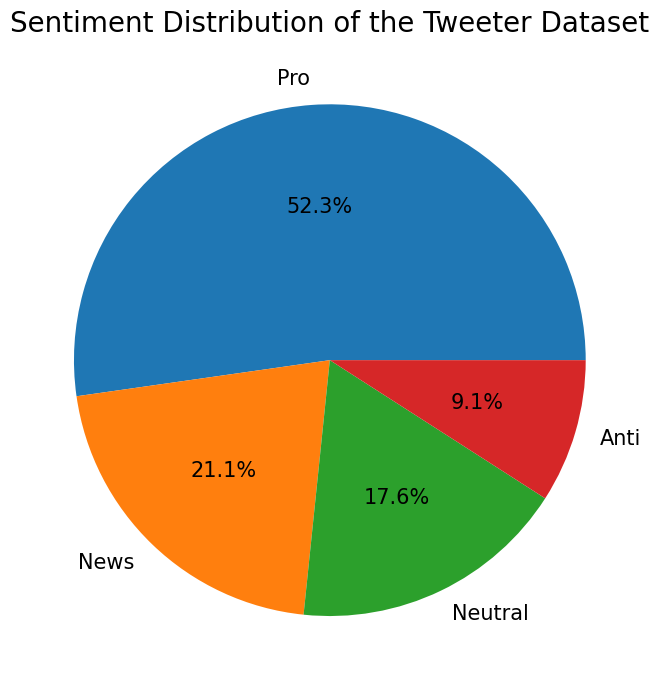

In [ ]:
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index,
        autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweeter Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
df.sentiment.value_counts()

sentiment
Pro        22962
News        9276
Neutral     7715
Anti        3990
Name: count, dtype: int64

# 3 Data Processing

The pre-processing involves several steps to clean and prepare the text data for further analysis:

* **Lowercase:** Convert all text to lowercase to ensure consistency and reduce noise.
* **Remove punctuation:** Remove punctuation marks that don't contribute to the meaning of the text.
* **Remove digits:** Remove numerical digits as they are not relevant for sentiment analysis.
* **Remove usernames:** Remove Twitter usernames (@ mentions) to focus on the content of the tweets.
* **Remove links:** Remove any URLs or hyperlinks present in the tweets.
* **Remove non-English words:** Use a regular expression to keep only English words and remove any non-English characters.
* **Remove stopwords:** Remove common words that don't add significant meaning, such as "the", "a", "an", etc.
* **Lemmatize:** Convert words to their base form (e.g., "running" to "run").
* **Tokenize:** Split the text into individual words or tokens.
* **Join tokens:** Combine the processed tokens back into a single string.

These steps help to clean and normalize the text data, removing noise and focusing on the relevant content for further analysis.

In [ ]:
# A list of common words in English (e.g., "the", "and", "is") that often carry little individual meaning.
nltk.download('stopwords')
# A sentence tokenizer, important for breaking down text into smaller units.
nltk.download('punkt')
# Required for lemmatization
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
printable = set(string.printable)  # From the string module

def remove_usernames_nltk(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return " ".join([token for token in tokens if not token.startswith('@')])

def preprocess(text, use_stemming=False):

    # Remove username/handle
    text = remove_usernames_nltk(text)

    # Remove non-printable characters
    text = ''.join(filter(lambda x: x in printable, text))

    # Splits the input text into individual words (tokens).
    tokens = nltk.word_tokenize(text)

    # Converts each word to lowercase. Keeps only alphabetic tokens (excludes punctuation, numbers).
    # Filters out stop words for cleaner analysis.
    tokens = [w.lower() for w in tokens if w.isalpha() and w not in stop_words]

    # Decide: Stemming or Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Additional Filtering
    additional_filters = [
        lambda token: not token.startswith('htt'),  # Remove URLs
        lambda token: not token.startswith('rt'), # Remove rt=retweet as it occurred frequently and not useful
        # Add more lambda functions for other filters, or directly specify bad words
    ]
    tokens = [token for token in tokens if all(f(token) for f in additional_filters)]

    # Joins the processed tokens back into a single string with spaces between them
    return " ".join(tokens)

df['cleaned_text'] = df['message'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df.head(20)

,sentiment,message,tweetid,cleaned_text
0,Anti,@tiniebeany climate change is an interesting h...,792927353886371840,climate change interesting hustle global warmi...
1,Pro,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,watch beforetheflood right travel world tackle...
2,Pro,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,fabulous leonardo dicaprio film climate change...
3,Pro,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,just watched amazing documentary leonardodicap...
4,News,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,pranita biswasi lutheran odisha give testimony...
5,Neutral,Unamshow awache kujinga na iko global warming ...,793125429418815489,unamshow awache kujinga na iko global warming
6,News,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125430236684289,pranita biswasi lutheran odisha give testimony...
7,News,RT @CCIRiviera: Presidential Candidate #Donald...,793126558688878592,presidential candidate donaldtrump dangerous c...
8,Neutral,RT @AmericanIndian8: Leonardo DiCaprio's clima...,793127097854197761,leonardo dicaprio climate change documentary f...
9,Pro,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028,beforetheflood watch beforetheflood right trav...


Duplicate removal is an important step in data pre-processing for several reasons:

1. **Eliminate Redundant Data:**
   Duplicate data can skew the results of analysis by overrepresenting certain observations. Removing duplicates ensures that each observation is counted only once, leading to more accurate and reliable results.

2. **Improve Efficiency:**
   Working with a dataset containing duplicate records can be computationally expensive and time-consuming. Removing duplicates reduces the size of the dataset, making it easier to process and analyze.

3. **Enhance Data Quality:**
   Duplicate records can introduce inconsistencies and errors into the data. Removing duplicates helps to improve the overall quality of the dataset, making it more suitable for further analysis and modeling.

4. **Prevent Biased Results:**
   Duplicate data can introduce bias into the analysis, especially if the duplicates are not randomly distributed. Removing duplicates helps to ensure that the results are representative of the entire dataset and not skewed by overrepresented observations.

5. **Facilitate Data Integration:**
   When integrating multiple datasets, it is essential to remove duplicate records to avoid double-counting and ensure consistency across the combined dataset.

6. **Improve Model Performance:**
   Training machine learning models on a dataset with duplicate records can lead to overfitting and decreased model performance. Removing duplicates helps to improve the generalization ability of the model and prevent it from learning from redundant information.

In [ ]:
# Remove duplicate message after preprocessing
unique_df = df.drop_duplicates(subset='cleaned_text')
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37764 entries, 0 to 43942
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentiment     37764 non-null  object
 1   message       37764 non-null  object
 2   tweetid       37764 non-null  int64 
 3   cleaned_text  37764 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


After removing duplicate messages, the data is reduced by 14% which is now 37764.

# 4 Topic Modelling

This section will explore the use of Latent Dirichlet Allocation (LDA), and BERTopic on the preprocessed Twitter climate change dataset.

**Latent Dirichlet Allocation (LDA)** is an unsupervised topic modeling technique that identifies hidden thematic structures within a collection of documents. We will apply LDA to the cleaned text data to discover the underlying topics and their associated keywords.

**BERTopic** is a topic modeling technique that leverages a neural network to identify topics and their relationships. We will utilize BERTopic to extract topics from the cleaned text data and visualize the topic clusters.

By combining these techniques, we aim to gain a deeper understanding of the topics discussed in the tweets and the relationships between different topics and sentiments.

## 4.1 LDA (Latent Dirichlet Allocation) by Sentiment

Latent Dirichlet Allocation (LDA) is a statistical method for identifying thematic structures in a collection of documents. It is a generative model, meaning that it assumes that the documents in the collection are generated from a mixture of topics, and that each topic is characterized by a distribution over words.

LDA is a good method for analyzing the Twitter climate change sentiment dataset because it can help to identify the different topics that are being discussed in the tweets, and how these topics relate to the different sentiment classes. This information can be used to gain a better understanding of the public opinion on climate change, and to identify the different arguments that are being made on both sides of the debate.

Here is a brief explanation of how LDA works:

1. **Preprocessing:** The first step is to preprocess the documents in the collection. This includes removing stop words, punctuation, and other irrelevant characters. This has been done in previous section.
2. **Topic modeling:** The next step is to build the LDA model. This involves specifying the number of topics to be identified, and the number of iterations to be run.
3. **Document representation:** The LDA model represents each document as a mixture of topics. Each topic is represented by a distribution over words, and each document is represented by a distribution over topics.
4. **Interpretation:** The final step is to interpret the results of the LDA model. This can be done by examining the words that are most associated with each topic, and by looking at the documents that are most representative of each topic.

LDA is a powerful tool for analyzing large collections of text data. It can be used to identify the main themes and topics in a collection of documents, and to understand how these topics relate to each other.


-------------------------------------------------------------------
 Sentiment: Anti
-------------------------------------------------------------------

Perplexity: 4425.973617278378

Topic 1: ['ice', 'not', 'scam', 'cause', 'fact', 'real', 'made', 'man', 'change', 'climate']
Topic 2: ['time', 'manipulated', 'blame', 'earth', 'year', 'data', 'al', 'gore', 'global', 'warming']
Topic 3: ['this', 'via', 'it', 'real', 'scam', 'scientist', 'snow', 'year', 'warming', 'global']
Topic 4: ['isi', 'know', 'weather', 'you', 'liberal', 'science', 'think', 'obama', 'change', 'climate']
Topic 5: ['left', 'trump', 'obama', 'it', 'new', 'the', 'warming', 'global', 'change', 'climate']
Topic 6: ['weather', 'paris', 'would', 'say', 'the', 'it', 'warming', 'global', 'change', 'climate']
Topic 7: ['believe', 'human', 'if', 'scientific', 'like', 'hoax', 'science', 'the', 'warming', 'global']
Topic 8: ['big', 'the', 'caused', 'so', 'get', 'carbon', 'tax', 'obama', 'change', 'climate']
Topic 9: ['hoax', 'w

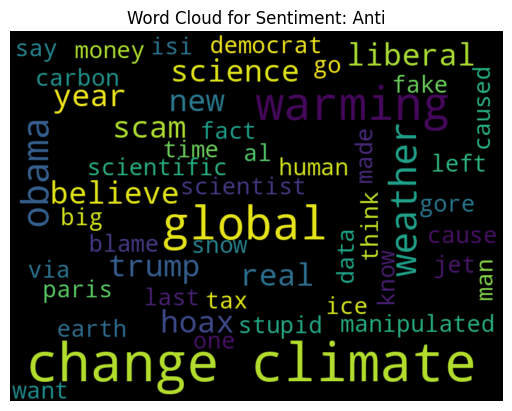


-------------------------------------------------------------------
 Sentiment: Neutral
-------------------------------------------------------------------

Perplexity: 2313.4219260581435

Topic 1: ['really', 'one', 'maybe', 'something', 'blame', 'due', 'need', 'the', 'warming', 'global']
Topic 2: ['it', 'like', 'cold', 'still', 'believe', 'if', 'na', 'real', 'warming', 'global']
Topic 3: ['what', 'human', 'want', 'the', 'epa', 'is', 'no', 'trump', 'change', 'climate']
Topic 4: ['special', 'money', 'sign', 'the', 'now', 'forget', 'world', 'how', 'change', 'climate']
Topic 5: ['like', 'you', 'must', 'think', 'it', 'thing', 'hot', 'cause', 'warming', 'global']
Topic 6: ['time', 'well', 'today', 'environment', 'caused', 'new', 'do', 'the', 'climate', 'change']
Topic 7: ['get', 'believe', 'leonardo', 'one', 'good', 'dicaprio', 'think', 'the', 'change', 'climate']
Topic 8: ['question', 'god', 'and', 'say', 'so', 'talking', 'look', 'like', 'change', 'climate']
Topic 9: ['conference', 'man',

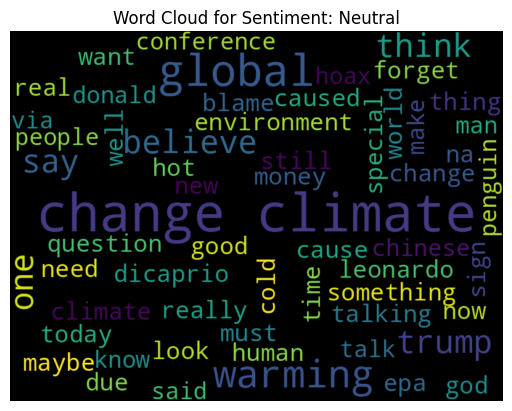


-------------------------------------------------------------------
 Sentiment: News
-------------------------------------------------------------------

Perplexity: 1340.2751100843577

Topic 1: ['via', 'policy', 'the', 'action', 'say', 'trump', 'leader', 'world', 'change', 'climate']
Topic 2: ['fight', 'post', 'study', 'time', 'scientist', 'say', 'the', 'new', 'change', 'climate']
Topic 3: ['could', 'report', 'via', 'agreement', 'impact', 'study', 'paris', 'new', 'change', 'climate']
Topic 4: ['administration', 'plan', 'president', 'epa', 'via', 'obama', 'donald', 'change', 'climate', 'trump']
Topic 5: ['call', 'china', 'francis', 'take', 'trump', 'pope', 'white', 'house', 'change', 'climate']
Topic 6: ['real', 'plan', 'trump', 'in', 'national', 'say', 'security', 'threat', 'change', 'climate']
Topic 7: ['carbon', 'study', 'climate', 'scott', 'pruitt', 'say', 'scientist', 'epa', 'warming', 'global']
Topic 8: ['news', 'expert', 'via', 'oil', 'what', 'energy', 'city', 'could', 'change'

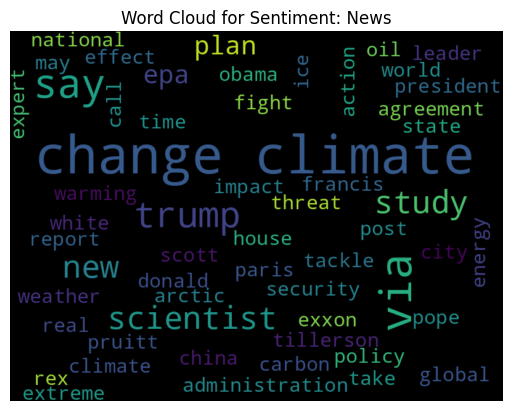


-------------------------------------------------------------------
 Sentiment: Pro
-------------------------------------------------------------------

Perplexity: 988.4007664421742

Topic 1: ['the', 'it', 'denier', 'fact', 'real', 'you', 'know', 'trump', 'change', 'climate']
Topic 2: ['national', 'water', 'way', 'security', 'energy', 'problem', 'fight', 'help', 'change', 'climate']
Topic 3: ['think', 'weather', 'like', 'still', 'believe', 'degree', 'it', 'real', 'warming', 'global']
Topic 4: ['human', 'head', 'scott', 'cause', 'carbon', 'pruitt', 'trump', 'epa', 'change', 'climate']
Topic 5: ['issue', 'via', 'talk', 'sea', 'city', 'world', 'how', 'the', 'change', 'climate']
Topic 6: ['emission', 'much', 'just', 'would', 'got', 'tree', 'day', 'earth', 'change', 'climate']
Topic 7: ['like', 'it', 'fight', 'the', 'take', 'action', 'need', 'we', 'change', 'climate']
Topic 8: ['effect', 'today', 'show', 'health', 'climatechange', 'the', 'impact', 'new', 'change', 'climate']
Topic 9: ['st

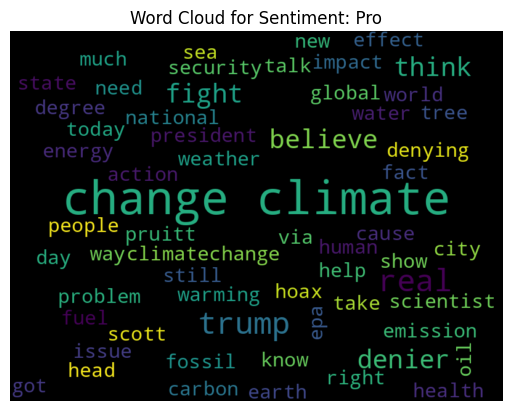

In [ ]:
from sklearn.metrics import make_scorer

grouped_df = unique_df.groupby('sentiment')

# TF-IDF Feature Engineering
vectorizer = TfidfVectorizer(max_features=2000)

# Data frame to store result of perplexity for each sentiment
perplexity_result = pd.DataFrame(columns=['Sentiment', 'Perplexity'])

class PerplexityScorer(BaseEstimator, TransformerMixin):
  def __init__(self, model):
    self.model = model

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    perplexity = self.model.perplexity(X)
    return np.array([-perplexity])  # Negate for minimization during GridSearch

for sentiment, group_df in grouped_df:

  # Split the data into training and testing sets
  train_data, test_data = train_test_split(group_df['cleaned_text'], test_size=0.2, random_state=42)

  # TF-IDF Feature Engineering
  vectorizer = CountVectorizer(max_features=2000)
  train_features = vectorizer.fit_transform(train_data)

  # LDA Model Training with GridSearch
  num_topics_range = range(10, 31, 5)  # Adjust range as needed
  lda_model = LatentDirichletAllocation(random_state=42)  # Set random state

  param_grid = {'n_components': num_topics_range}

  perplexity_scorer = make_scorer(PerplexityScorer.fit_transform, model=lda_model)
  grid_search = GridSearchCV(lda_model, param_grid, cv=5, scoring=perplexity_scorer)
  grid_search.fit(train_features)

  best_lda_model = grid_search.best_estimator_
  best_num_topics = grid_search.best_params_['n_components']

  # Perplexity Calculation
  test_features = vectorizer.transform(test_data)
  perplexity = best_lda_model.perplexity(test_features)

  # Add sentiment and perplexity to the DataFrame
  perplexity_result = pd.concat([perplexity_result, pd.DataFrame({'Sentiment': [sentiment], 'Perplexity': [perplexity]})], ignore_index=True)

  print("\n-------------------------------------------------------------------")
  print(f" Sentiment: {sentiment}")
  print("-------------------------------------------------------------------")

  print(f"\nPerplexity: {perplexity}\n")

  # Extract topics and top keywords
  topics = best_lda_model.components_
  keywords = vectorizer.get_feature_names_out()

  # Print top keywords per topic for each sentiment group
  for topic_idx, topic in enumerate(topics):
    top_keywords = [keywords[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx+1}:", top_keywords)

  print("\n")

  # Create a WordCloud by Sentiment
  all_keywords = [keywords[i] for topic in topics for i in topic.argsort()[-10:]]
  sentiment_wordcloud = WordCloud(width=800, height=600).generate(" ".join(all_keywords))

  plt.imshow(sentiment_wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Word Cloud for Sentiment: {sentiment}")
  plt.show()

**Top Keywords per Sentiment:**

* **Anti:** change, climate, hoax, scam, fake, global warming
* **Neutral:** climate change, global warming, talking, think, maybe
* **Pro:** climate change, global warming, action, need, future
* **News:** climate change, global warming, report, study, scientist

**Interpretation:**

* **Anti:** The top keywords for the "Anti" sentiment indicate a strong rejection of the concept of climate change, viewing it as a hoax or scam.
* **Neutral:** The top keywords for the "Neutral" sentiment reflect a more objective stance, discussing climate change and global warming without expressing a clear opinion.
* **Pro:** The top keywords for the "Pro" sentiment convey a sense of urgency and concern, emphasizing the need for action to address climate change.
* **News:** The top keywords for the "News" sentiment focus on reporting and scientific studies related to climate change, presenting factual information without expressing an opinion.

Overall, the top keywords per sentiment provide insights into the different perspectives and opinions expressed in the tweets about climate change.

In [ ]:
# Display consolidated perplexity result
perplexity_result

,Sentiment,Perplexity
0,Anti,4425.973617
1,Neutral,2313.421926
2,News,1340.275110
3,Pro,988.400766


The perplexity metric indicates the model's ability to predict new data. A lower perplexity value signifies that the model can better predict the unseen data. In the context of the provided output, the perplexity values for different sentiment groups suggest the following:

* **Pro:** For the "Pro" sentiment group, the perplexity is 988.40, suggesting that the model can predict new data for this group with relatively higher certainty compared to other groups.
* **News:** The model has a perplexity of 1340.28 for the "News" sentiment group. This implies that the model is relatively less certain in predicting new data belonging to this group.
* **Neutral:** The perplexity for the "Neutral" sentiment group is 2313.42,  This indicates that the model has moderate difficulty in predicting new data for this group compared to other groups.
* **Anti:** The "Anti" sentiment group has a perplexity of 4425.97, indicating that the model has great difficulty in predicting new data for this group.

Overall, the perplexity values suggest that the model has varying levels of difficulty in predicting new data for different sentiment groups within the Twitter climate change sentiment dataset.

## 4.2 BERTopic

### 4.2.1 Topic Modelling

In order to ensure a balanced representation of sentiments and expedite the topic modeling process, we opted for a subsample approach. Specifically, we randomly selected 1000 records from each sentiment category, providing an equal representation across sentiments while effectively reducing the computational time required for topic modeling.

In [ ]:
# Since dataset is very big and it will either crash or take a long time (>1hr),
# we will just get random 1000 rows for each sentiment

grouped_df = unique_df.groupby('sentiment')
sentiment_dfs = {}
for sentiment, group_df in grouped_df:
  sentiment_dfs[sentiment] = group_df[lambda x: x['cleaned_text'] != 'nan'].sample(n=1000, random_state=42)

# Merge all the data frames into a single data frame
subset_df = pd.concat(sentiment_dfs.values())

subset_df.head(100)

,sentiment,message,tweetid,cleaned_text
10456,Anti,RT @NotJoshEarnest: POTUS condemns the heinous...,815714576750747648,potus condemns heinous attack istanbul it star...
40669,Anti,RT @theREALdondeg: @lawiegers Saw u dislike cl...,694892479091499009,saw u dislike climate change hysteria u know c...
42709,Anti,#ClimateFraud https://t.co/KAmwdprINk,761608497234444288,climatefraud
34154,Anti,RT @NewUnitatevires: Oh crap! @LeoDiCaprio wil...,955093368438251526,oh crap ban sandwich jet flight counter global...
20620,Anti,New report about Antarctica is horrible news f...,859996180893270016,new report antarctica horrible news global war...
...,...,...,...,...
35577,Anti,Six more weeks of winter??? Where's global war...,958414302729457667,six week winter where global warming need al g...
39265,Anti,Watch: Second Worst Climate Change Video Ever ...,667830781583093760,watch second worst climate change video ever via
34528,Anti,Do not mistake the cause of global scale clima...,955795755683336199,do mistake cause global scale climate change i...
8376,Anti,RT @mikandynothem: Antarctic ice at record hig...,806323655999418368,antarctic ice record high level scientist expl...


In [ ]:
# Update with the location of the bert model
# /content/bertopic_model --> if manually loaded to notebook
model_path = "/content/drive/MyDrive/Colab Notebooks/bertopic_model"

if os.path.isfile(model_path):
  print("Loading existing model...")
  bertopic_model = BERTopic.load(model_path)
else:
  print("Training new model...")

  # BERTopic model creation
  bertopic_model = BERTopic(language="english", embedding_model="all-mpnet-base-v2",
                            calculate_probabilities=True)

  # Fit the model on your text data
  topics, topic_probs = bertopic_model.fit_transform(subset_df['cleaned_text'])

  # Save the model as it took more than 1hr to run
  bertopic_model.save("/content/drive/MyDrive/Colab Notebooks/bertopic_model", save_embedding_model=False)

Loading existing model...


Create a BERTopic instance, with the  following parameters:

* `language`: Set to "english"
* `embedding_model`: Choose a pre-trained language model like "all-mpnet-base-v2" (experiment with different models for optimal results)
* `calculate_probabilities`: Set to True to calculate topic probabilities for sentiment analysis integration (optional)

Use the `fit_transform` method on your text data to generate topics and topic probabilities (if applicable).

### 4.2.2 Topic-Keyword Association

In [ ]:
# Topic-Keyword Association (BERTopic)
top_keywords = bertopic_model.get_topic_info().sort_values(by='Count', ascending=False).head(10)

# Display top keywords for each topic
for topic_id, keywords in bertopic_model.get_topics().items():
    print(f"Topic {topic_id + 1} Keywords: {keywords}")

Topic 0 Keywords: [('change', 0.013079814358889191), ('climate', 0.01305807988442089), ('global', 0.012070270883726029), ('warming', 0.012048802555075065), ('the', 0.008642140069546366), ('trump', 0.008148905003014862), ('we', 0.006841886155164591), ('it', 0.0066721256383177685), ('say', 0.006148911817466253), ('world', 0.006146141706080015)]
Topic 1 Keywords: [('energy', 0.02291802511915256), ('action', 0.022777311042312603), ('fight', 0.018766873265431732), ('wind', 0.018597099628082942), ('need', 0.018414699474447658), ('join', 0.01726807421619288), ('adaptation', 0.016509790549767214), ('we', 0.015251749423548226), ('climate', 0.014853651005120606), ('change', 0.014633685123093333)]
Topic 2 Keywords: [('scientific', 0.03637882692531932), ('science', 0.0338139036525202), ('scientist', 0.030015325678736635), ('evidence', 0.02590582889756563), ('hoax', 0.020649882361899605), ('fake', 0.019259378960463168), ('fact', 0.018487566800399008), ('data', 0.017456773843974597), ('consensus', 0

### 4.2.3 BERTopic Visualization

In [ ]:
bertopic_model.get_topic_freq()

,Topic,Count
2,-1,1836
15,0,155
10,1,133
17,2,103
13,3,92
...,...,...
19,62,12
62,63,11
54,64,11
67,65,11


The output of `bertopic_model.get_topic_freq()` shows the frequency of each topic in the dataset. This information can be used to understand the distribution of topics and identify the most prominent themes in the text data.

The DataFrame has two columns: “Topic” and “Count”. Each row represents a topic, identified by an integer, and its corresponding count, which represents the frequency of the topic in the dataset.

**Topic -1** has the highest count (1836), which is significantly higher than the other topics. This could suggest that **Topic -1** might be collecting noise or non-specific information.

The other topics have lower counts, indicating their respective frequencies in the dataset.

In [ ]:
bertopic_model.visualize_topics()

The output of `bertopic_model.visualize_topics()` is a set of visualizations that provide insights into the topics identified by the BERTopic model. These visualizations can be used to understand the relationships between different topics, identify key words and phrases associated with each topic, and explore the distribution of documents across topics.

Here's how to interpret the visualizations:

1. **Topic map:** This visualization shows the topics as points on a two-dimensional map. The distance between points represents the semantic similarity between topics. Topics that are closer together are more similar in terms of their content and keywords.

2. **Topic bar chart:** This chart displays the frequency of each topic in the dataset. The height of each bar corresponds to the number of documents assigned to that topic.

3. **Topic heatmap:** This heatmap shows the top words and phrases associated with each topic. The color intensity indicates the relevance of each word or phrase to the topic. Darker colors represent higher relevance.

4. **Document topic distribution:** This plot shows the distribution of documents across topics. Each document is represented by a point on the plot, and the color of the point indicates the topic it belongs to.

By analyzing these visualizations, you can gain a deeper understanding of the topics in your text data and how they relate to each other. This information can be used for various purposes, such as topic modeling, document clustering, and identifying key themes and trends in the data.

Here are some specific insights you can extract from the visualizations:

* **Topic similarity:** Identify which topics are most similar and most dissimilar based on their proximity on the topic map.

* **Topic dominance:** See which topics are most prevalent in the dataset based on the height of their bars in the topic bar chart.

* **Key words and phrases:** Explore the top words and phrases associated with each topic in the topic heatmap to understand the main themes and concepts represented by each topic.

* **Document distribution:** See how documents are distributed across topics in the document topic distribution plot. This can help you identify documents that cover multiple topics or documents that are outliers in terms of their topic assignment.

By interpreting the visualizations generated by `bertopic_model.visualize_topics()`, you can gain a deeper understanding of the topics in your text data and how they relate to each other. This information can be used for various purposes, such as topic modeling, document clustering, and identifying key themes and trends in the data.

In [ ]:
bertopic_model.visualize_barchart(top_n_topics=20)

The `bertopic_model.visualize_barchart()` method generates a bar chart that displays the frequency of each topic in the dataset. The height of each bar corresponds to the number of documents assigned to that topic.

There are 12 topics labeled from Topic 0 to Topic 11. Each topic has a set of words with colored bars representing their scores. The length of the bars represents the score of each word within that specific topic. Here's a brief interpretation of the topics based on the prominent words:

**Topic 0** and **Topic 1** discuss energy action and scientific evidence respectively.
**Topic 2** is about weather conditions.
**Topic 4** focuses on global warming.
**Topic 6** involves agriculture and food, which are impacted by climate change.
**Topic 9** addresses arctic melting, a result of global warming.
**Topic 11** refers to Trump's decision on the Paris agreement, a key climate change accord.

Each topic represents a collection of words that frequently appear together in your dataset. The score of each word indicates its relevance or frequency within that topic.

In [ ]:
bertopic_model.visualize_heatmap(top_n_topics = 20)

The `bertopic_model.visualize_heatmap()` method generates a heatmap that displays the top words and phrases associated with each topic. The color intensity indicates the relevance of each word or phrase to the topic. Darker colors represent higher relevance.

The heatmap shows the top 20 topics and their associated words. Each row represents a topic, and each column represents a word or phrase. The color intensity indicates the relevance of the word or phrase to the topic.

For example, the word "climate" is highly relevant to Topic 0, as indicated by the dark color of the cell in the first row and first column. This means that documents assigned to Topic 0 frequently mention the word "climate".

Similarly, the word "global" is highly relevant to Topic 4, and the word "arctic" is highly relevant to Topic 9.

By analyzing the heatmap, you can gain a deeper understanding of the topics in your text data and how they relate to each other. You can see which words and phrases are most characteristic of each topic, and how different topics are related based on their shared words and phrases.

Here are some specific insights you can extract from the heatmap:

* **Topic similarity:** Identify which topics are most similar and most dissimilar based on their shared words and phrases.
* **Key words and phrases:** Explore the top words and phrases associated with each topic to understand the main themes and concepts represented by each topic.
* **Topic evolution:** Track how topics change and evolve over time by comparing heatmaps generated from different time periods.

By interpreting the heatmap generated by `bertopic_model.visualize_heatmap()`, you can gain a deeper understanding of the topics in your text data and how they relate to each other. This information can be used for various purposes, such as topic modeling, document clustering, and identifying key themes and trends in the data.

In [ ]:
bertopic_model.visualize_hierarchy(top_n_topics = 20)

The `bertopic_model.visualize_hierarchy()` method generates a tree diagram that shows the hierarchical relationships between topics. This visualization can be used to understand how topics are related to each other and identify potential subtopics or overarching themes.

By analyzing the hierarchy diagram, you can gain insights into the following:

* **Topic hierarchy:** See how topics are organized into a hierarchical structure, with higher-level topics representing broader themes and lower-level topics representing more specific subtopics.
* **Topic relationships:** Identify which topics are closely related and which ones are more distinct. This can help you understand the overall structure and organization of the topics in your text data.
* **Subtopic discovery:** Explore the subtopics associated with each main topic. This can help you identify potential areas for further investigation or analysis.

Here's an example of how to interpret the hierarchy diagram:

* If Topic 1 is a parent topic with subtopics 2, 3, and 4, it suggests that Topic 1 represents a broader theme that encompasses several more specific subtopics.
* If Topic 5 is a child topic of Topic 1, it suggests that Topic 5 is a more specific subtopic within the broader theme represented by Topic 1.
* If Topic 10 is a sibling topic of Topic 5, it suggests that both topics are related but represent distinct themes or subtopics.

By interpreting the topic hierarchy diagram, you can gain a deeper understanding of the relationships between topics in your text data and how they are organized into a hierarchical structure. This information can be used for various purposes, such as topic modeling, document clustering, and identifying key themes and trends in the data.